# Überblich von NN, GBD und KNN

Im Folgenden wird ein Überblick über die einzelnen Algorithmen gegeben. Die einzelnen Optimierungsalgorithmen (speziell für GBD und NN) konnten hier nicht erneut ausgeführt werden, da sie sehr rechenintensiv sind. Sie wurde getrennt von hier auf einer dafür optimierten Azure VM ausgeführt. Die Skripte dazu können gefunden werden unter: !!!!!!!!!!!!!!!!!

## Imports:

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from numpy import array

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import shap

from sklearn.neighbors import KNeighborsClassifier

import warnings
# block all warning
warnings.filterwarnings('ignore')

## Datenaufbereitung

In [78]:
data = pd.read_csv("data_prepared_and_ready_numeric_2.csv", sep=";")
dummy_vars = data[["population_density", "no_rooms_range", "newly_const", "balcony", "has_kitchen", "cellar", "lift", "garden", "category_rent"  ]]
numerical_vars = data.drop(["population_density", "no_rooms_range", "newly_const", "balcony", "has_kitchen", "cellar", "lift", "garden", "category_rent"  ], axis=1)
#build dummies for categorial vars
categorial_list = ["population_density", "no_rooms_range"]
for var in categorial_list:
    new_dummies = pd.get_dummies(dummy_vars[var],prefix=var)
    dummy_vars = dummy_vars.join(pd.DataFrame(new_dummies), how='outer')
    del dummy_vars[var]

scale = StandardScaler()  
cols = numerical_vars.columns
numerical_vars = scale.fit_transform(numerical_vars)
numerical_vars = pd.DataFrame(data=numerical_vars, columns=cols)
numerical_vars.reset_index(drop=True, inplace=True)
dummy_vars.reset_index(drop=True, inplace=True)
#merge both types of variables
export_data = dummy_vars.join(numerical_vars, how='outer')

Die Daten werden in eine 80/20 Split aufgeteilt. 80% Training und 20% Validation

In [79]:
# Splitting Data into dependent (Y) and independent (X) variables.
Y = export_data[["category_rent"]]
X = export_data.drop(["category_rent"], axis=1)

# Splitting Data into Testing and Training Data.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=32)


## Gradient Boosted Decision Tree (GBD)

Im Folgenden werden die Einstellungen für den GBD eingestellt. Hier wird jetzt nur der optimale GBD ausgeführt. Das Skript für die Optimierung, was im Grunde nur noch die jeweiligen Einstellungen nach den Rauten mit einbezieht, kann im Anhang gefunden werden.

In [80]:

'''
Optimize Gradient Boosted Decision Tree Algorithm for the prediction.
'''

"""
Range of values to be used for each Setting of the gradient-boosting-algorithm.
In this instance we have already tested for what the best performing algorithm is, thefore we only implement this ons
The comments after each setting show the other values that the algorithm was trained on"""
rate_learning_list = [0.1] #, 0.25, 0.5
max_depth_list = [6] #4, 5, 6, 7, 8
n_estimators_list = [1] # 20, 100, 
max_features_list = [13] # 3, 7, 

# A list to save all the results and one to count the number of models.
count_model = 0
all_results = {}
highestAccuracy = {"accuracy": 0, "algorith": ""}

Jetzt wird das Modell aufgebaut. 

In [81]:

# Looping through all values for each setting and saving the results.
for learning_rate in rate_learning_list:
    for max_depth in max_depth_list:
        for max_features in max_features_list:
            for n_estimators in n_estimators_list:
                # Save characteristics (settings) of model.
                all_results[count_model] = {"name":count_model, "learning_rate":learning_rate, "max_depth":max_depth, "max_features":max_features, "n_estimators":n_estimators}
                # Define characteristics (settings) of model.
                all_results[count_model]["gb_clf"] = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_features=max_features, max_depth=max_depth, random_state=32)
                # Build model with traing data.
                all_results[count_model]["gb_clf"].fit(x_train,y_train.values.ravel())
                # Test model on testing (validation) Dataset and save results.
                all_results[count_model]["accuracy_training"] = all_results[count_model]["gb_clf"].score(x_train, y_train)
                all_results[count_model]["accuracy_validation"] = all_results[count_model]["gb_clf"].score(x_test, y_test)
                # Check if model is the best for further investigation.
                if all_results[count_model]["accuracy_validation"] > highestAccuracy["accuracy"]:
                    highestAccuracy["accuracy"] = all_results[count_model]["accuracy_validation"]
                    highestAccuracy["algorith"] = all_results[count_model]
                count_model += 1

Jetzt überprüfen wir die Ergebnisse von unserem Modell. Hier nochmal die Einstellungen:

In [82]:
'''
Check performance and feature importance of optimal Boosted Gradient Decsion Tree Model.
'''

# Show the information of the best model
print("The model has the following specifications:")
print(str("learning_rate = " + str(highestAccuracy["algorith"]["learning_rate"]) + ", max_depth = " + str(highestAccuracy["algorith"]["max_depth"]) + ", max_features = " + str(highestAccuracy["algorith"]["max_features"]) + ", n_estimators = " + str(highestAccuracy["algorith"]["n_estimators"])))

The model has the following specifications:
learning_rate = 0.1, max_depth = 6, max_features = 13, n_estimators = 1


Die Ergebnisste anhang der Genauigkeit (Accuracy)

In [83]:
print(str("Accuracy (training) = " + str(highestAccuracy["algorith"]["accuracy_training"])))
print("Accuracy (validation) = " + str(highestAccuracy["algorith"]["accuracy_validation"]))

Accuracy (training) = 0.3025199580007
Accuracy (validation) = 0.30672310922969237


Jetz lassen wir und die Confussion Matrix anzeigen. 

In [84]:
# Show confusion matrix and classification report of model.
prediction = highestAccuracy["algorith"]["gb_clf"].predict(x_test)
print("Confusion Matrix:")
print(str(confusion_matrix(y_test, prediction)))

Confusion Matrix:
[[   0 2929    0    0    0    0    0    0]
 [   0 9197    0    0    0    0    0    0]
 [   0 5761    0    0    0    0    0    0]
 [   0 4016    0    0    0    0    0    0]
 [   0 2798    0    0    0    0    0    0]
 [   0 1733    0    0    0    0    0    0]
 [   0 1029    0    0    0    0    5    0]
 [   0 2533    0    0    0    0    0    0]]


Hier noch der Classifikation Report mit gängigen Kennzahlen

In [85]:
print("Classification Report")
print(str(classification_report(y_test, prediction)))

Classification Report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2929
           2       0.31      1.00      0.47      9197
           3       0.00      0.00      0.00      5761
           4       0.00      0.00      0.00      4016
           5       0.00      0.00      0.00      2798
           6       0.00      0.00      0.00      1733
           7       1.00      0.00      0.01      1034
           8       0.00      0.00      0.00      2533

    accuracy                           0.31     30001
   macro avg       0.16      0.13      0.06     30001
weighted avg       0.13      0.31      0.14     30001



## Variablen Einfluss

Jetzt überprüfen wir den Einfluss der einzelnen Variablen in unserem GBD-Algorithmus. 

In [86]:
# Check feature importance.

# Check feature importance of best model.
feature_importance = highestAccuracy["algorith"]["gb_clf"].feature_importances_
sorted_idx = np.argsort(feature_importance)


Jetzt überprüfen wir wie groß der Einfluss von den demographischen und ökonomische Kennzahlen in %

In [87]:
# Check the cumulated feature importance of demographic Data.
list_demographisch = ["Bevoelkerung_m","Bevoelkerung_w","LON","LAT","Siedlungsdichte_Schluessel","Arbeitslosenquote","Arbeitslose","AvgAge_total","AvgAge_female","AvgAge_male","BIP","BIP_pro_Einwohner","BIP_pro_Erwerbstaetige","Einkommen_proKopf","Einkommen_total","Arbeitslosenquote_bl","AvgAge_male_bl","BIP_pro_Einwohner_bl","newlyConst","balcony","hasKitchen","cellar","lift","garden","Siedlungsdichte_Name"]
counter = 0
for i, n in enumerate(np.array(export_data.columns)[sorted_idx]):
    if n in list_demographisch:
        counter += feature_importance[sorted_idx][i]
print(str(counter))

0.05131598478797124


Als letztes noch der Variablen Einfluss als Diagramm

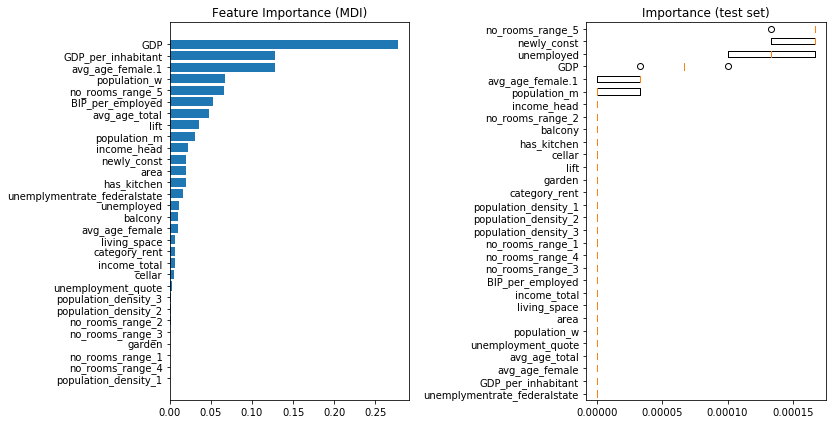

In [88]:
# Build plot to show feature importance.
# Source of Code: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(export_data.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')
result = permutation_importance(highestAccuracy["algorith"]["gb_clf"], x_test, y_test, n_repeats=5, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,vert=False, labels=np.array(export_data.columns)[sorted_idx])
plt.title("Importance (test set)")
fig.tight_layout()
plt.show()

## NN

Als erstes teilen wir den Datensatz wieder in Training und Testing auf

In [91]:
Y = export_data[["category_rent"]]
X = export_data.drop(["category_rent"], axis=1)
Y_encoded = to_categorical(Y)
x_train, x_test, y_train, y_test =    train_test_split(X, Y_encoded, test_size=0.2, random_state=32)

Jetzt bauen wir den NN-Algorithmus mit den optimierten Einstellungen auf. Die Optimierung kann im Anhang gefunden werden. Sie kann aus Performance gründen nur auf einern dafür optimierten Cloud umgebung berechnet werden.
Hier die Genauigkeit des Modells (Accuracy)

In [93]:
model = Sequential()
model.add(Dense(30, input_dim=30, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

hist = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0,validation_data=(x_test, y_test))
scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: ", scores[1])

30001/30001 [==============================] - 2s 51us/step
Accuracy:  0.5381487011909485


Im folgenden prüfen wir ob das Modell überschätzt (overfitting). 

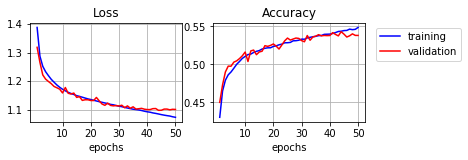

In [94]:
#performance benchmarks
history = hist.history
accuracy = history["accuracy"]
loss = history["loss"]
accuracy_val = history["val_accuracy"]
loss_val = history["val_loss"]
x= list(range(1,51,1))
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.title("Loss")
plt.plot(x, loss, color='blue', label='training')
plt.plot(x, loss_val, color='red', label='validation')
plt.xlabel("epochs")
plt.xticks([10,20,30,40,50])
plt.grid()

plt.subplot(2, 2, 2)
plt.title("Accuracy")
plt.plot(x, accuracy, color='blue', label='training')
plt.plot(x, accuracy_val, color='red', label='validation')

plt.xlabel("epochs")
plt.grid()
plt.xticks([10,20,30,40,50])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.show()

## KNN

Die Daten werden in eine 80/20 Split aufgeteilt. 80% Training und 20% Validation. Wieder mit dem gleichen Seed, damit die Aufteilung über alle Modelle hinweg gleich ist. 

In [95]:
Y = export_data[["category_rent"]]
X = export_data.drop(["category_rent"], axis=1)
x_train, x_test, y_train, y_test =    train_test_split(X, Y, test_size= .2, random_state=32)

Die Optimierung von k - die im Anhang gefunden werden kann - hat folgenden Ergebnisse ergeben: 

![title](Optimierung.png)

Jetzt betrachten wir nur das Ergebnis des optimalen Modells:

In [97]:
clf1=KNeighborsClassifier(n_neighbors = 11)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf1.fit(x_train,y_train.values.ravel())

y_pred1=clf1.predict(x_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred1))

Accuracy: 0.5324155861471285
